In [1]:
'''
---------------------------------------------------
Simple way to fit Three 2D-Gaussians for FOXSI3-SLF Data (Dark corrected)
Then get the FWHM as a function of the azimuthal angle
---------------------------------------------------

Goal: To fit Three 2D gaussians to the FOXSI3 SLF data corrected by darks.

Input:  1. Fits file with SLF Data taken with the Andor CCD Camera.
        2. Dark fits files for correction.

Run on terminal: ipython 02_fit_three_2D_Gaussians.py

Output:
            1. Flat plots of the three 2D-Gaussians in Log scale.
            2. 3D plots of the three 2D-Gaussians.
            3. Plot of the difference Data vs. Fit in log scale.
            4. Print out the parameters for the three 2D-Gaussians and the offset.
            5. Plot of the FWHM as a function of the azimuthal angle

Date: Aug, 2019
Author: Milo
UC-Berkeley
'''

''' INPUTS '''

XX = 0.0   ## in arcmins
YY = 0.0   ## in arcmins

print('Pitch = {0} arcmin, Yaw = {1}'.format(str(XX),str(YY)))

'''' File names: '''
filename = 'X2-No-WA-PSF/FOXSI3_X2_CCD_T6Sx6_10kV_0p02mA_0arcminX_0arcminY.fits'  ## name of your data fits file.
darkfilename = 'Darks/Dark1_FOXSI3_X2_CCD_T6Sx6_10kV_0p02mA_0arcminX_0arcminY.fits'  ## name of your darks fits file.
## These are fits files containing six frames each of 1024x1024 pixels taken at the SLF
## using the Andor camera and the Mo X-ray source. Voltages,Currents and Integration Times are
## indicated over the names of the files.

## Path to the folder where to find your data and darks:
folder = '/Volumes/Pandora/FOXSI/OpCal/FOXSI-3_2018Mar/X2-10Shells/CCD/'
## Path to the folder where to save all the outcomes:
# SaveFolder = '/Users/Kamilobu/Desktop/OffAxisFWHM_X2_OldBlockers/{0}Pitch&{1}Yaw'.format(str(XX),str(YY))
SaveFolder = '/Users/Kamilobu/Desktop/'

''' Workspace '''
## Import Packages:
from astropy import wcs
from astropy.io import fits as pyfits
from ndcube import NDCube
from astropy.visualization import ImageNormalize, MinMaxInterval, LogStretch, LinearStretch
from astropy.modeling import models, fitting
from mpl_toolkits import mplot3d
from scipy.optimize import brentq
import astropy.units as u
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Workspace:
''' Plate scale '''
distance = 2. * u.m ## FOXSI focal distance
CCD_PIXEL_PITCH = 13.5 * u.micron ## Andor CCD Pitch in microns
binning = 2. ## binning used for collecting data.
plate_scale = np.arctan(binning * CCD_PIXEL_PITCH / distance).to(u.arcsec) ## in arcsec

## Read fits files using astropy.io.fits
fits = pyfits.open(folder+filename)
darkfits = pyfits.open(folder+darkfilename)

## Create data array corrected by darks:
data = np.average(fits[0].data, axis=0) - np.average(darkfits[0].data, axis=0)
smax_pixel = np.unravel_index(np.argmax(data), data.shape)
fov = [20, 20] ## [px,px]
sdata = data[smax_pixel[0]-fov[0]:smax_pixel[0]+fov[0],smax_pixel[1]-fov[1]:smax_pixel[1]+fov[1]]/data.max()
max_pixel = np.unravel_index(np.argmax(sdata), sdata.shape)

''' Create the WCS information '''
wcs_dict = {
    'CTYPE1':'HPLT-TAN', ## To use sunpy this needs to be in helioporject coord.
    'CTYPE2':'HPLN-TAN', ## Although strange, it does not affect any of the analysis.
    'CUNIT1':'arcsec',
    'CUNIT2':'arcsec',
    'CDELT1': plate_scale.value, ## Plate scale in arcsec
    'CDELT2': plate_scale.value, ## Plate scale in arcsec
    'CRPIX1':0,
    'CRPIX2':0,
    'CRVAL1': 0,
    'CRVAL2': 0,
    'NAXIS1': sdata.shape[0],
    'NAXIS2': sdata.shape[1]
}
input_wcs = wcs.WCS(wcs_dict)

''' Create NDCube '''
datacube = NDCube(sdata, input_wcs)

''' Definition of Two 2D-Gaussians function '''
@models.custom_model
def ThreeGaussians(x, y,
                 x_mean=0, y_mean=0, theta=0,
                 amp1=0, x1_stddev=0, y1_stddev=0, ## Gauss1 param
                 amp2=0, x2_stddev=0, y2_stddev=0, ## Gauss2 param
                 amp3=0, x3_stddev=0, y3_stddev=0, ## Gauss3 param
                 offset=0): ## offset
    ''' Constrain positive values for the amplitudes '''
    if amp1 < 0:
        amp1 = 1e12
    if amp2 < 0:
        amp2 = 1e12
    if amp3 < 0:
        amp3 = 1e12

    '''Define Sum of Gauss funtions'''
    g1 = models.Gaussian2D(amp1, x_mean, y_mean, x1_stddev, y1_stddev, theta)
    g2 = models.Gaussian2D(amp2, x_mean, y_mean, x2_stddev, y2_stddev, theta)
    g3 = models.Gaussian2D(amp3, x_mean, y_mean, x3_stddev, y3_stddev, theta)
    ''' Defining Offset '''
    oset = models.Const2D(amplitude=offset)
    return g1(x,y) + g2(x,y) + g3(x,y) + oset(x,y)

## Make X,Y,Z data for the TWO 2D-Gaussians:
Xg, Yg = np.mgrid[0:datacube.data.shape[0], 0:datacube.data.shape[1]]

''' Fit Three 2D-Gaussians '''
## Initial Guess :
ThreeG_guess = ThreeGaussians(x_mean=max_pixel[0], y_mean=max_pixel[1], theta=0,
                          amp1=0.24160*np.max(datacube.data),
                          amp2 = 0.25626*np.max(datacube.data),
                          amp3 = 0.50214*np.max(datacube.data),
                          x1_stddev=2.0, y1_stddev=2.0,
                          x2_stddev=2.0, y2_stddev=2.0,
                          x3_stddev=2.0, y3_stddev=2.0,offset=0)

## Finding best fit:
fit2DG = fitting.LevMarLSQFitter()
ThreeG_out = fit2DG(ThreeG_guess, Xg, Yg, datacube.data, maxiter=300) ## maxiter keyword is the max number of iterations.
Zout = ThreeG_out(Xg, Yg)

## Individual Gaussian Functions:
g1 = models.Gaussian2D(ThreeG_out.amp1.value, ThreeG_out.x_mean.value,
                       ThreeG_out.y_mean.value, ThreeG_out.x1_stddev.value,
                       ThreeG_out.y1_stddev.value, ThreeG_out.theta.value)
g2 = models.Gaussian2D(ThreeG_out.amp2.value, ThreeG_out.x_mean.value,
                       ThreeG_out.y_mean.value, ThreeG_out.x2_stddev.value,
                       ThreeG_out.y2_stddev.value, ThreeG_out.theta.value)
g3 = models.Gaussian2D(ThreeG_out.amp3.value, ThreeG_out.x_mean.value,
                       ThreeG_out.y_mean.value, ThreeG_out.x3_stddev.value,
                       ThreeG_out.y3_stddev.value, ThreeG_out.theta.value)
### Individual Gaussian Arrays:
G1 = g1(Xg, Yg)
G2 = g2(Xg, Yg)
G3 = g3(Xg, Yg)

''' R^2 function definition '''
## More info: https://en.wikipedia.org/wiki/Coefficient_of_determination
def RSquared(data,model):
    ## The closest to 1, the better is the fit.
    ss_err=(model.fit_info['fvec']**2).sum()
    ss_tot=((data-data.mean())**2).sum()
    return 1-(ss_err/ss_tot)
''' Estimate R^2 '''
RS3G = RSquared(data, fit2DG)
'''  Chi Square '''
chisq = scipy.stats.chisquare(datacube.data[np.abs(Zout) >= 1e-15], f_exp=Zout[np.abs(Zout) >= 1e-15])

''' Plot Flat Fitted Gaussians  '''
# Create ImageNormalize objects:
normLogT = ImageNormalize(Zout, interval=MinMaxInterval(),stretch=LogStretch())
normLog1 = ImageNormalize(G1, interval=MinMaxInterval(),stretch=LogStretch())
normLog2 = ImageNormalize(G2, interval=MinMaxInterval(),stretch=LogStretch())
normLog3 = ImageNormalize(G3, interval=MinMaxInterval(),stretch=LogStretch())

''' Plotting '''
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8),
                                             subplot_kw=dict(projection=datacube.wcs))
fig.subplots_adjust(wspace = 0.4) ## Sets space between subplots to avoid overlap
## Best fit of the all three gaussians:
im1 = ax1.imshow(Zout, origin='lower', cmap=plt.cm.viridis,norm=normLogT)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax1.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax1.set_title('Three 2D-GaussFit Log scale',fontsize=14)
## Gaussian One:
im2 = ax2.imshow(G1, origin='lower', cmap=plt.cm.viridis,norm=normLog1)
cbar2 = fig.colorbar(im2,ax=ax2)
ax2.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax2.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax2.set_title('2D-Gaussian One - Log scale',fontsize=14)
## Gaussian Two:
im3 = ax3.imshow(G2, origin='lower', cmap=plt.cm.viridis,norm=normLog2)
cbar3 = fig.colorbar(im3,ax=ax3)
ax3.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax3.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax3.set_title('2D-Gaussian Two - Log scale',fontsize=14)
## Gaussian Two:
im4 = ax4.imshow(G3, origin='lower', cmap=plt.cm.viridis,norm=normLog3)
cbar4 = fig.colorbar(im4,ax=ax4)
ax4.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax4.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax4.set_title('2D-Gaussian Three - Log scale',fontsize=14)
plt.savefig(SaveFolder+'_Flat.png')
#plt.show()

''' Print what the amplitud ratios are '''
print('The amplitud ratios for the guessed three 2D-Gaussians are: A1 = {0:.5f}, A2 = {1:.5f}, and {2:.5f}.'
      .format(round(ThreeG_guess.amp1.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
              round(ThreeG_guess.amp2.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
              round(ThreeG_guess.amp3.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
       ))
print('The amplitud ratios for the three 2D-Gaussians are: A1 = {0:.5f}, A2 = {1:.5f}, and {2:.5f}.'
      .format(round(ThreeG_out.amp1.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
              round(ThreeG_out.amp2.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
              round(ThreeG_out.amp3.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
       ))
print('The standard deviation for the three 2D-Gaussians are: S1x = {0:.5f}, S1y = {1:.5f}, S2x = {2:.5f}, S2y = {3:.5f}, S3x = {4:.5f}, and S3y = {5:.5f}.'
      .format(round(ThreeG_out.x1_stddev.value,5),
              round(ThreeG_out.y1_stddev.value,5),
              round(ThreeG_out.x2_stddev.value,5),
              round(ThreeG_out.y2_stddev.value,5),
              round(ThreeG_out.x3_stddev.value,5),
              round(ThreeG_out.y3_stddev.value,5),
       ))
phi = np.rad2deg(ThreeG_out.theta.value-(ThreeG_out.theta.value//np.pi)*np.pi)
print('Offset = {0:.5f}'.format(round(ThreeG_out.offset.value,5)))
print('Angle = {0:.5f} degrees'.format(round(phi,3)))
print('$R^2$ for three gaussians is {0:.5f}'.format(round(RS3G,5)))
print('$chi^2$ for three gaussians is {0:.5f}'.format(round(chisq[0]/(Zout.shape[0]*Zout.shape[1]),5)))

''' Plot  3D Fitted Gaussians '''

''' Clipping data '''
fov = [7,7]
sXg = Xg[max_pixel[0]-fov[0]:max_pixel[0]+fov[0],max_pixel[1]-fov[1]:max_pixel[1]+fov[1]]
sYg = Yg[max_pixel[0]-fov[0]:max_pixel[0]+fov[0],max_pixel[1]-fov[1]:max_pixel[1]+fov[1]]
sZout = ThreeG_out(sXg, sYg)
sG1 = g1(sXg, sYg)
sG2 = g2(sXg, sYg)
sG3 = g3(sXg, sYg)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8),
                                             subplot_kw=dict(projection='3d'))
ax1.plot_surface(sXg,sYg,sZout,cmap=plt.cm.viridis)
ax1.set_title('Three 2D-GaussFit',fontsize=14)
ax1.set_zlim3d(0, sZout.max())
ax2.plot_surface(sXg,sYg,sG1,cmap=plt.cm.viridis)
ax2.set_title('2D-Gaussian One',fontsize=14)
ax2.set_zlim3d(0, sZout.max())
ax3.plot_surface(sXg,sYg,sG2,cmap=plt.cm.viridis)
ax3.set_title('2D-Gaussian Two',fontsize=14)
ax3.set_zlim3d(0, sZout.max())
ax4.plot_surface(sXg,sYg,sG3,cmap=plt.cm.viridis)
ax4.set_title('2D-Gaussian Three',fontsize=14)
ax4.set_zlim3d(0, sZout.max())
plt.savefig(SaveFolder+'_3D.png'.format(str(XX),str(YY)))
#plt.show()


''' Plot Difference Data vs Fit '''
diff = (datacube.data-Zout)
diffmax = (np.array(diff.max(),-diff.min())).max()
fov = [15,15]
fig, ax1 = plt.subplots(figsize=(6,6),subplot_kw=dict(projection=datacube.wcs))
im1 = ax1.imshow(diff, origin='lower', cmap=plt.cm.bwr_r,vmin=-diffmax,vmax=diffmax)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax1.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax1.set_title('Difference Data vs Fit - Log scale',fontsize=18)
plt.savefig(SaveFolder+'_Diff.png'.format(str(XX),str(YY)))
#plt.show()


''' Estimate of the FWHM on X&Y '''

def x_fwhm_minmax(G3):
    factor = 4*np.sqrt(2*np.log(2))*(G3.x1_stddev+
                                     G3.x2_stddev+G3.x3_stddev)
    x_fwhm_min = brentq(G3,G3.x_mean.value-factor,
                            G3.x_mean.value,args=(G3.y_mean.value))
    x_fwhm_max = brentq(G3,G3.x_mean.value,
                            G3.x_mean.value+factor,args=(G3.y_mean.value))
    return(x_fwhm_min,x_fwhm_max)

def G3y(y,x,G3): ## Flip argument order. Needed to find zeros on y-axis.
    return G3(x,y)

''' Find the FWHM '''
def find_fwhm(G3,x): ## Input should be a 3-2D-Gaussian Function. e.g. ThreeG_out
    factor = 4*np.sqrt(2*np.log(2))*(G3.y1_stddev+
                                     G3.y2_stddev+G3.y3_stddev)
    y_fwhm_down = brentq(G3y,G3.y_mean.value-factor,
                            G3.y_mean.value,args=(x,G3))
    y_fwhm_up = brentq(G3y,G3.y_mean.value,
                            G3.y_mean.value+factor,args=(x,G3))
    return (y_fwhm_down,y_fwhm_up)

maximum = ThreeG_out.amp1.value \
            + ThreeG_out.amp2.value \
            + ThreeG_out.amp3.value
half_maximum = 0.5 * maximum
ThreeG_out.offset -= half_maximum

npoints = 50
x_fwhm = ThreeG_out.x_mean+(ThreeG_out.x_mean -
                   x_fwhm_minmax(ThreeG_out)[0]-1e-3)*np.sin((np.pi/2)*np.linspace(-1,1,npoints))
y_fwhm_up_l,y_fwhm_down_l = [],[]
for x in x_fwhm:
    y_fwhm = find_fwhm(ThreeG_out,x)
    y_fwhm_down_l.append(y_fwhm[0])
    y_fwhm_up_l.append(y_fwhm[1])
y_fwhm_down = np.array(y_fwhm_down_l)
y_fwhm_up = np.array(y_fwhm_up_l)

ThreeG_out.offset += half_maximum

''' Plotting a Map of the FWHM '''
# Create ImageNormalize objects:
normLogT = ImageNormalize(Zout, interval=MinMaxInterval(),stretch=LogStretch())
r_up = np.sqrt((x_fwhm-ThreeG_out.x_mean)**2 + (y_fwhm_up-ThreeG_out.y_mean)**2)
r_down = np.sqrt((x_fwhm-ThreeG_out.x_mean)**2 + (y_fwhm_down-ThreeG_out.y_mean)**2)
phi_up = np.arctan2((y_fwhm_up-ThreeG_out.y_mean),(x_fwhm-ThreeG_out.x_mean))
phi_down = np.arctan2((y_fwhm_down-ThreeG_out.y_mean),(x_fwhm-ThreeG_out.x_mean))

r = np.concatenate((r_up,r_down))
phi = np.concatenate((phi_up,phi_down))
## Polar Plot:
fig, ax = plt.subplots(figsize=(5,5),subplot_kw=dict(projection='polar'))
ax.plot(phi, 2*r*plate_scale,'o')
ax.set_rmax(14)
ax.set_rmin(3)
#ax.set_rticks([6, 6.5, 7, 7.5, 8])
ax.set_title("FWHM vs. azimuthal angle",fontsize=20)
plt.savefig(SaveFolder+'_FWHM.png')
#plt.show()
print('FWHM for {0} arcmin in Pitch and {1} arcmin in Yaw:'.format(str(XX),str(YY)))
print('The average FWHM over the azimuthal angle is {0} arcsecs.'.format(round(2*r.mean()*plate_scale.value,4)))


Pitch = 0.0 arcmin, Yaw = 0.0
The amplitud ratios for the guessed three 2D-Gaussians are: A1 = 0.24160, A2 = 0.25626, and 0.50214.
The amplitud ratios for the three 2D-Gaussians are: A1 = 0.23082, A2 = 0.24673, and 0.52246.
The standard deviation for the three 2D-Gaussians are: S1x = 1.05046, S1y = 2.20503, S2x = 1.27715, S2y = 2.25037, S3x = 2.36996, and S3y = 2.39156.
Offset = 0.00934
Angle = 19.96300 degrees
$R^2$ for three gaussians is 1.00000
$chi^2$ for three gaussians is 0.01247
FWHM for 0.0 arcmin in Pitch and 0.0 arcmin in Yaw:
The average FWHM over the azimuthal angle is 13.0856 arcsecs.


# Sanity check using matplotlib FWHM contour

In [2]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
#Z = (Z1 - Z2) * 2
Z = (Z1) * 2

In [3]:
Z.max()

2.0

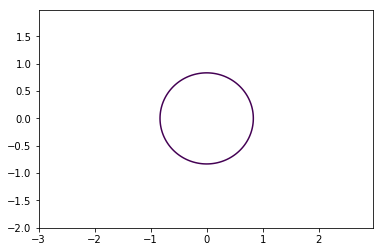

In [4]:
levels = np.array([.5*Z.max()])
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z, levels )
#ax.clabel(CS, inline=1, fontsize=10)
#ax.set_title('Simplest default with labels')

In [5]:
p = CS.collections[0].get_paths()[0]
v = p.vertices

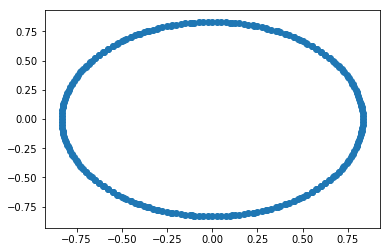

In [6]:
plt.scatter(v[:,0],v[:,1])